In [358]:
import os
import sys
import pandas as pd
import numpy as np
import plotnine
from plotnine import *
import seaborn as sns
import matplotlib as plt


from plydata.cat_tools import *


dir_base = os.getcwd()
dir_data = os.path.join(dir_base, 'data')
dir_figures = os.path.join(dir_base, 'figures')
dir_output = os.path.join(dir_base, 'output')
assert os.path.exists(dir_data)
dir_pho = os.path.join(dir_data,'PHO')
assert os.path.exists(dir_pho)
if not os.path.exists(dir_figures):
  os.mkdir(dir_figures)
  
if not os.path.exists(dir_output):
  os.mkdir(dir_output)

"""## (1.A) Merge data from PHO

https://www.publichealthontario.ca/en/data-and-analysis/substance-use/interactive-opioid-tool
"""

fn_data = pd.Series(os.listdir(dir_pho))
fn_data = fn_data[fn_data.str.contains('\\.csv$')]
holder = []
for fn in fn_data:
  tmp_phu = fn.split(',')[1]
  tmp_df = pd.read_csv(os.path.join(dir_pho,fn))
  tmp_df.insert(0,'phu',tmp_phu)
  holder.append(tmp_df)
# Merge and clean
df_phu = pd.concat(holder).reset_index(None,True)

cn_drop = ['change of ED visits (%)','change of Hospitalizations (%)','change of Deaths (%)']
di_cn = {'phu':'PHU','Year - Month':'date','Population':'population',
         'Rate of ED visits':'rate_ED','Count of ED visits':'count_ED',
         'Rate of Hospitalizations':'rate_hosp',
         'Count of Hospitalizations':'count_hosp',
         'Rate of Deaths':'rate_death','Count of Deaths':'count_death'}
df_phu = df_phu.drop(columns=cn_drop).rename(columns=di_cn)
df_phu.PHU = df_phu.PHU.str.strip()

df_phu.PHU = df_phu.PHU.str.replace('\\sHealth\\sUnit','')
df_phu.PHU = df_phu.PHU.str.replace('\\sPublic\\sHealth','')
df_phu.date = pd.to_datetime(df_phu.date.str.replace('\\s\\-\\s','-')+'-01')
df_phu.to_csv(os.path.join(dir_output,'df_phu.csv'),index=False)

"""## (1.B) Append data from Coroner's office"""

path = os.path.join(dir_data,'ON_Opioid_Deaths_Jan-Sept 2020 by PHU_Jan 29 2021_cleaned.csv')
df_cor = pd.read_csv(path)
df_cor.rename(columns={'Unnamed: 0':'PHU'},inplace=True)
df_cor.PHU = df_cor.PHU.str.replace('\\sHealth\\sUnit','')
df_cor.PHU = df_cor.PHU.str.replace('\\sPublic\\sHealth','')

di_fix = {'Leeds, Grenville & Lanark District':'Leeds',
          'Kingston, Frontenac and Lennox & Addington Publi':'Kingston',
          'Haliburton, Kawartha, Pine Ridge District Health':'Haliburton'}
tmp = df_cor.PHU.map(di_fix)
df_cor.PHU = np.where(tmp.isnull(),df_cor.PHU,tmp)
df_cor = df_cor.loc[1:].melt('PHU',None,'date','n').sort_values(['PHU','date'])
df_cor = df_cor.assign(idx=lambda x: x.date.str.split('\\.',2,True).iloc[:,1],
              date=lambda x: x.date.str.replace('\\.[1-2]',''))
df_cor = df_cor.assign(idx=lambda x: np.where(x.idx.isnull(),0,x.idx).astype(int))
df_cor = df_cor.assign(tt=lambda x: x.idx.map({0:'confirmed',1:'probable',2:'total'})).drop(columns='idx')
df_cor.date = df_cor.date.str.replace('\\s2020','')
tmp = df_cor.date.map({'Aug':'August','Sep':'September'})
df_cor.date = np.where(tmp.isnull(),df_cor.date,tmp)
df_cor.date = pd.to_datetime(df_cor.date+',2020',format='%B,%Y')
df_cor.n = df_cor.n.astype(float).fillna(0).astype(int)
# Double check total == confirmed + probable
assert df_cor.groupby(['PHU','tt']).n.sum().reset_index().pivot('PHU','tt','n').assign(check=lambda x: x.confirmed+x.probable==x.total).check.all()
# Merge Huron County and Perth District to Huron Perth
df_cor = df_cor.assign(PHU=lambda x: np.where(x.PHU.isin(['Huron County','Perth District']),'Huron Perth',x.PHU))
df_cor = df_cor.groupby(['PHU','date','tt']).n.sum().reset_index()
tmp1 = df_phu[['PHU','date','population','count_death']].rename(columns={'count_death':'n'})
tmp1 = tmp1.query('date >= 2005 & date<="2020-03-01"').assign(n=lambda x: x.n.astype(int))
tmp2 = df_cor.query('tt=="confirmed"').drop(columns='tt')
df_both = tmp1.merge(tmp2,'outer',['PHU','date'])
# df_both.query('date>=2020 & date<="2020-03-01"').assign(check=lambda x: x.n_x==x.n_y).query('check==False')
df_both = df_both.assign(n_death = lambda x: np.where(x.n_y.isnull(),x.n_x,x.n_y).astype(int)).drop(columns=['n_x','n_y'])
df_both.population = df_both.groupby('PHU').population.fillna(method='ffill').astype(int)
df_both = df_both.sort_values(['PHU','date']).reset_index(None, True)
df_both = df_both.assign(year=lambda x: x.date.dt.strftime('%Y').astype(int),
                          month=lambda x: x.date.dt.strftime('%m').astype(int))
df_both.to_csv(os.path.join(dir_output,'df_deaths.csv'),index=False)

"""## (2) Census Data"""


In [371]:
# https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/prof/details/download-telecharger/comp/page_dl-tc.cfm?Lang=E
# https://www.stthomastimesjournal.com/2018/05/10/marr-asks-provincial-candidates-to-invest-in-public-health-spending

u_PHU = pd.Series(df_both.PHU.unique())
# Load in the Census data
di_census = {'CENSUS_YEAR':'year', 'GEO_NAME':'geo',
             'DIM: Profile of Health Regions (2247)':'cn',
             'Dim: Sex (3): Member ID: [1]: Total - Sex':'value'}
path = os.path.join(dir_data,'census_healthregions.csv')
df_census = pd.read_csv(path,usecols=list(di_census),low_memory=False)
df_census = df_census.rename(columns=di_census)
df_census.geo = df_census.geo.str.split('\\s\\/\\s',1,True).iloc[:,0].str.strip()
u_geo = pd.Series(df_census.geo.unique())

# Find a dictionary mapping
di_PHU = {}
for phu in u_PHU:
    mtch = list(u_geo[u_geo.str.contains(phu)])
    if len(mtch) == 1:
        mtch = mtch[0]
        di_PHU[mtch] = phu
    #print('PHU: %s, match: %s\n' % (phu, mtch))
    #break
# Manually assign the missing
di_PHU['City of Hamilton Health Unit'] = 'City of Hamilton Services'
di_PHU['Durham Regional Health Unit'] = 'Durham Region Health Department'
di_PHU['Hastings and Prince Edward Counties Health Unit'] = 'Hastings Prince Edward'
di_PHU['Sudbury and District Health Unit'] = 'Public Health Sudbury & Districts'
di_PHU['Waterloo Health Unit'] = 'Region of Waterloo and Emergency Services'
di_PHU['Elgin-St. Thomas Health Unit'] = 'Southwestern'
di_PHU['Oxford County Health Unit'] = 'Southwestern'
di_PHU['City of Toronto Health Unit'] = 'Toronto'
di_PHU['Huron County Health Unit'] = 'Huron Perth'
di_PHU['Perth District Health Unit'] = 'Huron Perth'
# Keep only dictionary terms
df_census = df_census[df_census.geo.isin(list(di_PHU))]
df_census = df_census.assign(geo=lambda x: x.geo.map(di_PHU)).rename(columns={'geo':'PHU'})
# Term mapper
di_cn = {'Population, 2016':'population',
         'Land area in square kilometres':'area_km2',
        'Separated':'seperated',
        'Divorced':'divorced',
        'Married or living common law':'married',
        'Median after-tax income in 2015 among recipients ($)':'income',
        'Number of government transfers recipients aged 15 years and over in private households - 100% data':'num_transfers',
        'Market income (%)':'pct_market',
        'Employment income (%)':'pct_employment',
        'Government transfers (%)':'pct_govt',
        # ---'Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)',
        '0 to 17 years (%)':'poverty_child',
        '18 to 64 years (%)':'poverty_adult',
        '23 Construction':'construction',
        'Unemployment rate':'unemp',
        'Participation rate':'particp'}
df_census = df_census[df_census.cn.isin(list(di_cn))].reset_index(None, True)
df_census.cn = df_census.cn.map(di_cn)
df_census['idx'] = df_census.groupby(cn_gg).cumcount()
# Select the "first" poverty measure
df_census = df_census.sort_values(cn_gg+['idx']).groupby(cn_gg).head(1).reset_index(None,True).drop(columns='idx')
# Merge Huron and Perth to Huron Perth
cn_gg = ['year','PHU', 'cn']
df_census = df_census.groupby(cn_gg).value.sum().reset_index()
# Do feature transformations
cn_idx = ['year','PHU']
df_census_wide = df_census.pivot_table('value',cn_idx,'cn',lambda x: x).reset_index()
cn_val = df_census_wide.columns.drop(cn_idx).values
df_census_wide[cn_val] = df_census_wide[cn_val].astype(float)
# Normalize counts by population
cn_ratio = ['construction', 'divorced', 'married', 'seperated', 'num_transfers']
df_census_wide[cn_ratio] = df_census_wide[cn_ratio].divide(df_census_wide.population,axis=0)
# Combined divorced and separated
df_census_wide = df_census_wide.assign(divorce_sep=lambda x: x.divorced + x.seperated).drop(columns=['divorced','seperated'])
# Make shares into percentages
cn_share = ['particp', 'pct_employment', 'pct_govt', 'pct_market', 'poverty_adult', 'poverty_child', 'unemp']
df_census_wide[cn_share] = df_census_wide[cn_share] / 100
# Remove population
df_census_wide.drop(columns='population', inplace=True)
# Put pack into long-format
df_census = df_census_wide.melt(cn_idx)

In [367]:
# Remove any multicollinear columns
cn_val = df_census_wide.columns.drop(cn_idx).values
dat_rho = df_census_wide[cn_val].corr()

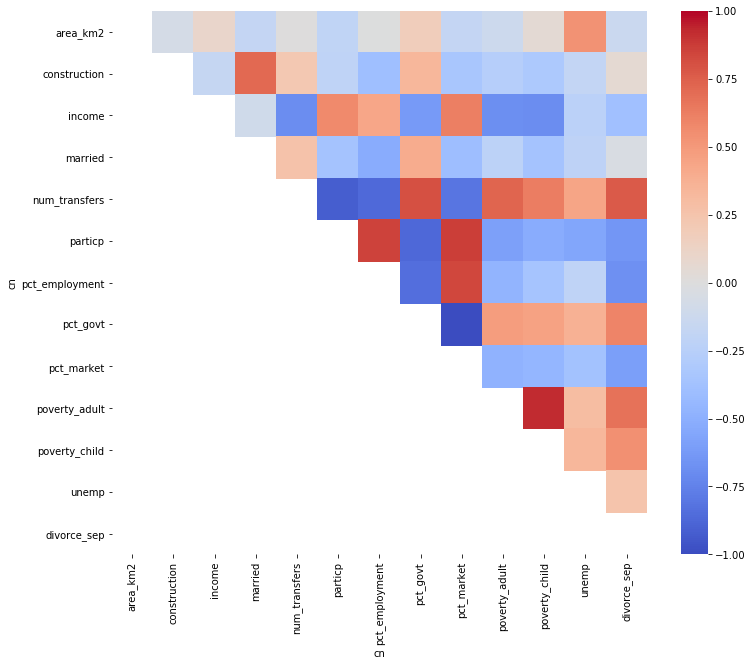

In [368]:
plt.rcParams['figure.figsize'] = [12, 10]
sns.heatmap(dat_rho,mask=np.tril(np.ones(dat_rho.shape)).astype(np.bool),cmap='coolwarm')

In [376]:
df_census.to_csv(os.path.join(dir_output, 'df_census.csv'),index=False)